In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import metrics
#%pip install lightgbm
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
bd17 = pd.read_csv('/content/drive/My Drive/Базы/AAPL17.csv', sep=',')
bd18 =  pd.read_csv('/content/drive/My Drive/Базы/AAPL18.csv', sep=',')
bd19 =  pd.read_csv('/content/drive/My Drive/Базы/AAPL19.csv', sep=',')
#df_2020 = pd.read_csv("/home/mlb/Job/nlp_trading/src/polygon/data/2020/AAPL.csv")
bd20 =  pd.read_csv('/content/drive/My Drive/Базы/AAPL21.csv', sep=',')

In [4]:
def remove_colon(x):
    return x[:-6]

df = pd.concat([bd17, bd18, bd19, bd20])
df['date'] = df['date'].apply(lambda x: remove_colon(x))
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d %H:%M:%S")
df = df.set_index(pd.DatetimeIndex(df['date']))

day_df = df.resample('1D').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last','volume':'sum'})
day_df = day_df[~day_df['close'].isna()]

In [5]:
fast_ma=20
slow_ma=40
day_df['fast_ma']=day_df['close'].rolling(window=fast_ma).mean()
day_df['slow_ma']=day_df['close'].rolling(window=slow_ma).mean()

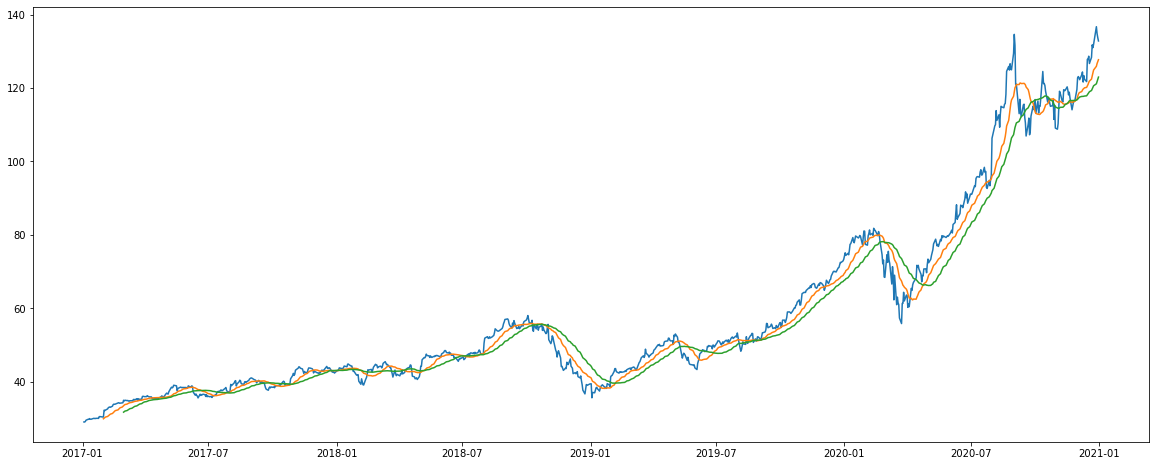

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.plot(day_df['close'], label = 'APPL')
plt.plot(day_df['fast_ma'], label = 'fast_ma')
plt.plot(day_df['slow_ma'], label = 'slow_ma')

In [ ]:
bd=pd.DataFrame()#создаю промежуточную базу для сигналоа по ма
bd['close']=day_df['close']
bd['fast_ma']= day_df['fast_ma']
bd['slow_ma'] = day_df['slow_ma']
bd


In [8]:
def buy_sell(day_df):         # функция сигналов покупки продажи
  signal_price_buy = []
  signal_price_sell = []
  flag = -1
  for i in range(len(day_df)):
    if day_df['fast_ma'][i]> day_df['slow_ma'][i]:
      if flag !=1:
        signal_price_buy.append(day_df['close'][i])
        signal_price_sell.append(np.nan)
        flag = 1
      else:
        signal_price_buy.append(np.nan)
        signal_price_sell.append(np.nan)
    elif day_df['fast_ma'][i] < day_df['slow_ma'][i]:
      if flag != 0:
        signal_price_buy.append(np.nan)
        signal_price_sell.append(day_df['close'][i])
        flag = 0
      else:
        signal_price_buy.append(np.nan)
        signal_price_sell.append(np.nan)
    else:
        signal_price_buy.append(np.nan)
        signal_price_sell.append(np.nan)
  return(signal_price_buy, signal_price_sell)

In [9]:
buy_sell = buy_sell(bd)


In [10]:
day_df['buy_signal'] = buy_sell[0] # добавляю в основной датафрейм 
day_df['sell_signal'] = buy_sell[1]

<function matplotlib.pyplot.legend(*args, **kwargs)>

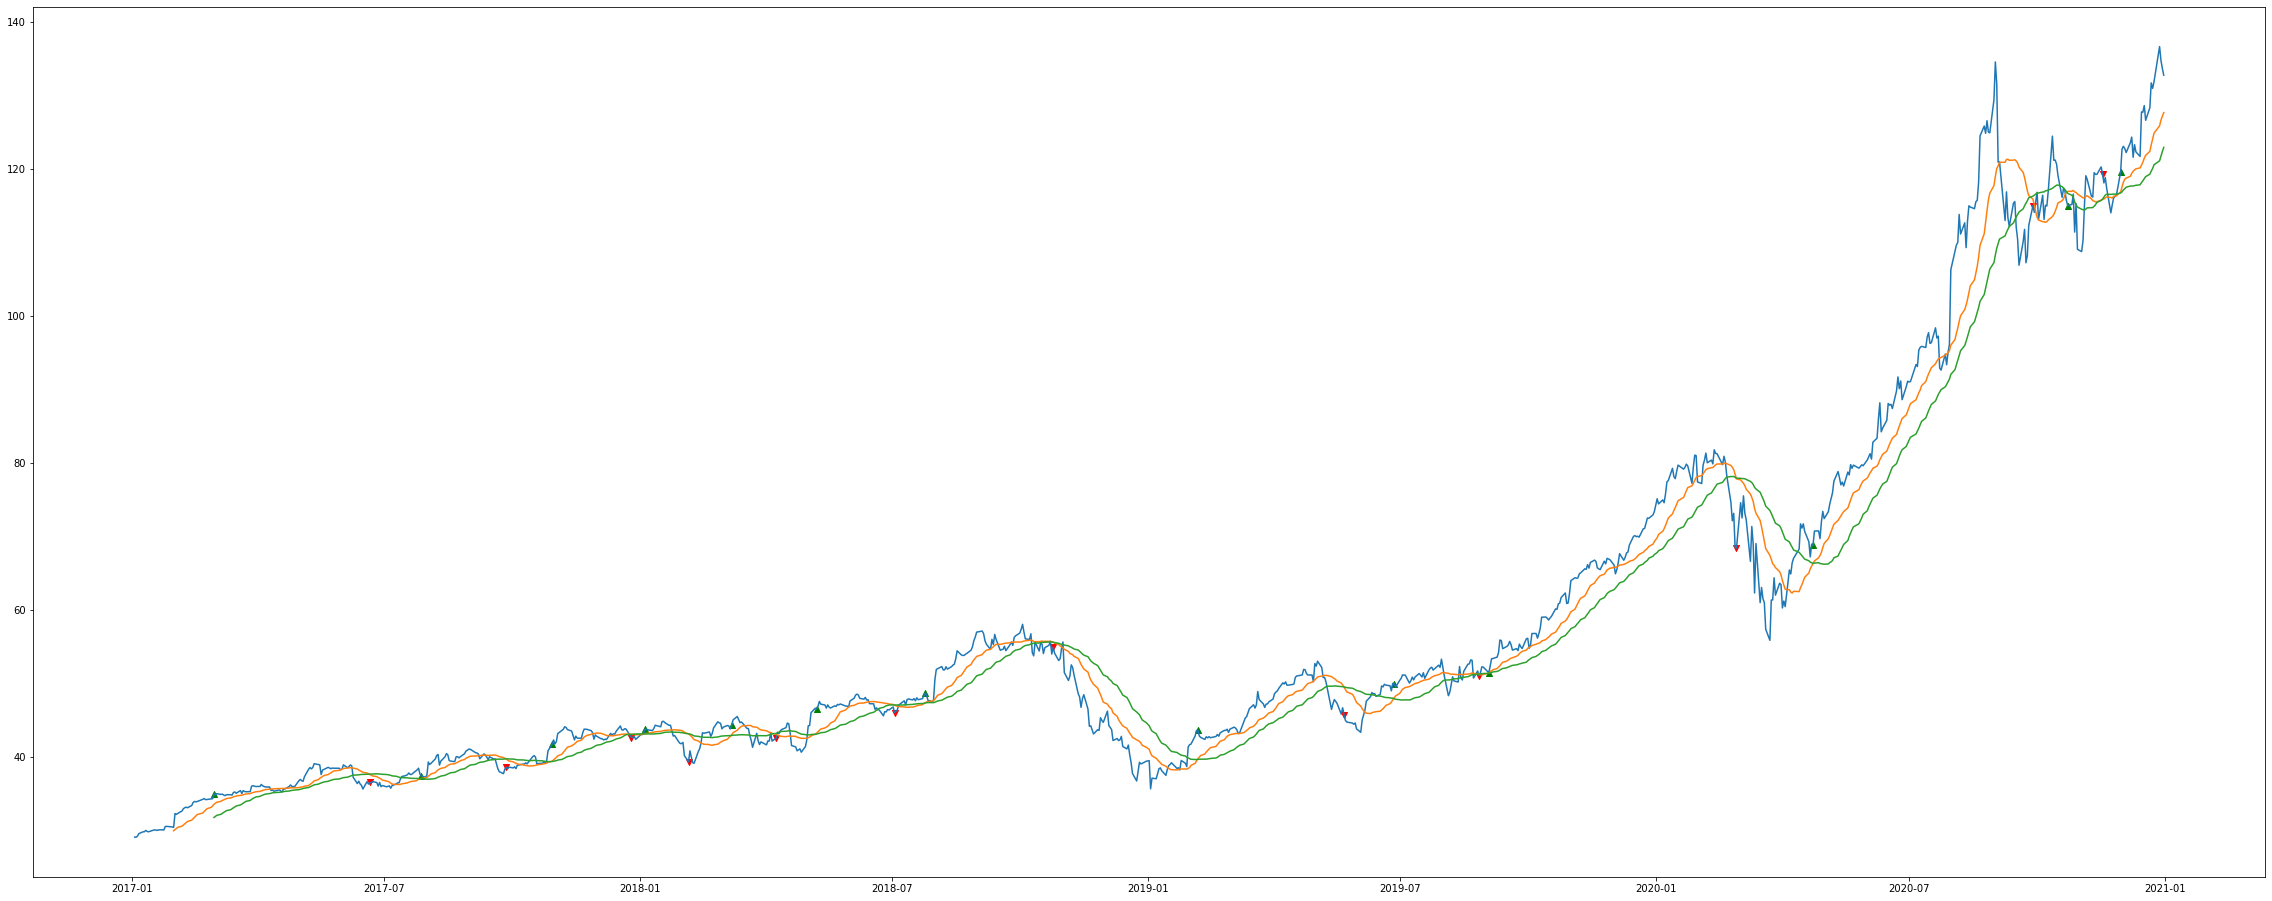

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,16))
plt.plot(day_df['close'], label = 'APPL')
plt.plot(day_df['fast_ma'], label = 'fast_ma')
plt.plot(day_df['slow_ma'], label = 'slow_ma')
plt.scatter(day_df.index, day_df['buy_signal'], label ='buy', marker='^', color = 'green')
plt.scatter(day_df.index, day_df['sell_signal'], label ='sell', marker='v', color = 'red')
plt.legend

In [ ]:
day_df['pct_change'] = day_df['close'].pct_change() #Добавляю колонку с процентным изменением за один торговый день 
day_df

In [13]:
day_df['STRATEGY'] = day_df['pct_change']*(day_df['fast_ma']>day_df['slow_ma']) - day_df['pct_change']*(day_df['fast_ma']<day_df['slow_ma']) # реализация торговой системы покупка продажа
day_df

,open,high,low,close,volume,fast_ma,slow_ma,buy_signal,sell_signal,pct_change,STRATEGY
date,,,,,,,,,,,
2017-01-03,28.9500,29.0825,28.6900,29.0225,102572716.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,28.9625,29.1275,28.9375,29.0025,74946512.0,NaN,NaN,NaN,NaN,-0.000689,0.000000
2017-01-05,28.9800,29.2161,28.9525,29.1525,83368768.0,NaN,NaN,NaN,NaN,0.005172,0.000000
2017-01-06,29.1950,29.5400,29.1175,29.4925,116451676.0,NaN,NaN,NaN,NaN,0.011663,0.000000
2017-01-09,29.4875,29.8575,29.4850,29.7450,122837968.0,NaN,NaN,NaN,NaN,0.008561,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,131.3200,133.4600,131.1000,131.9000,52379452.0,124.88775,120.594615,NaN,NaN,0.006947,0.006947
2020-12-28,133.9900,137.3400,133.5100,136.6900,114229847.0,125.89925,121.129365,NaN,NaN,0.036315,0.036315
2020-12-29,138.0500,138.7890,134.3409,134.8000,112655196.0,126.66025,121.772615,NaN,NaN,-0.013827,-0.013827


In [14]:
day_df = day_df.drop(day_df.index[0:slow_ma-1]) # дропаю все строки которые равны  медленной ма-1 

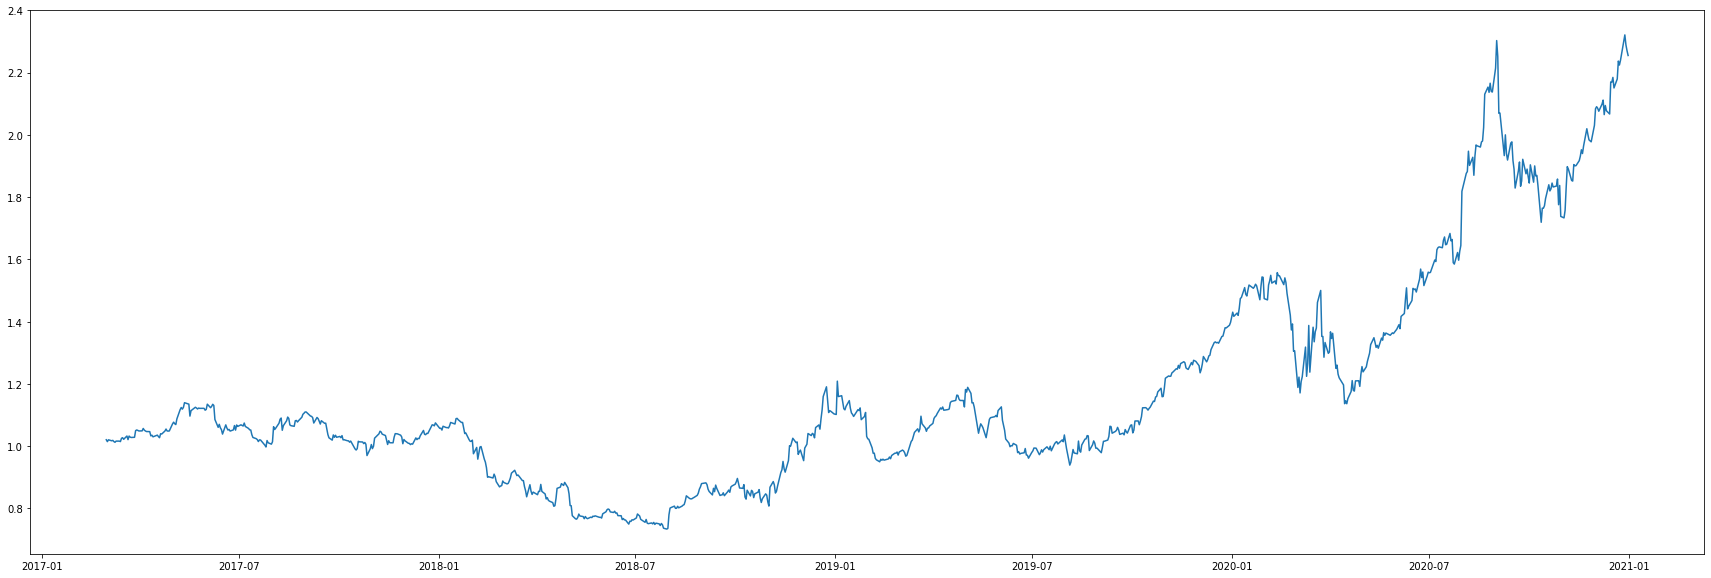

In [15]:
import matplotlib.pyplot as plt                #график доходности видим что с 17 по  21 год  просадка была порядка 25 процентов а доход в 120% 
plt.figure(figsize=(30,10))
plt.plot(np.cumprod(1+day_df['STRATEGY']))

In [ ]:
day_df1 = day_df.reset_index() #создаю доп дф для вычеслений
day_df1

In [18]:
def buy_sell_df(day_df):
  buy_sell_1 = pd.DataFrame(columns=['DATA', 'close', 'signal']) # создали пустой датафрейм  с именами колонок
  signal_price_buy = []
  signal_price_sell = []
  flag = -1
  for i, j in day_df.iterrows():
    if day_df['fast_ma'][i]> day_df['slow_ma'][i]:
      if flag !=1:
        data = j[0]
        close=day_df['close'][i]
        signal = 'buy'
        new_row = {'DATA': data, 'close': close, 'signal': signal} 
        buy_sell_1 = buy_sell_1.append(new_row, ignore_index=True)
        flag = 1
      else:
        signal_price_buy.append(np.nan)
        signal_price_sell.append(np.nan)
    elif day_df['fast_ma'][i] < day_df['slow_ma'][i]:
      if flag != 0:
        data = j[0]
        close=day_df['close'][i]
        signal = 'sell'
        new_row = { 'DATA': data, 'close': close, 'signal': signal} 
        buy_sell_1 = buy_sell_1.append(new_row, ignore_index=True)
        flag = 0
      else:
        signal_price_buy.append(np.nan)
        signal_price_sell.append(np.nan)
    else:
        signal_price_buy.append(np.nan)
        signal_price_sell.append(np.nan)
  return(buy_sell_1)

In [ ]:
aa=buy_sell_df(day_df1)
aa

In [ ]:
index=0  # ЗДЕСЬ  ЗАПИСЫВАЮ В ДАТАФРЕЙМ В ОДНУ СТРОКУ  СИГНАЛ ПОКУПКИ И ПРОДАЖИ ДЛЯ КОНФЬЮЖИН МАТРИКС
open_pos = 0
position = pd.DataFrame(columns=['data_open_pos', 'price_open_pos', 'signal','price_close_pos', 'data_close_pos'])
for i, j in aa.iterrows():
  if index == 0:
    open_pos = j[1]
    data_open_pos = j[0]
    signal = j[2]
    index = index+1
  elif index == 1:
    close_pos =j[1]
    data_close_pos=j[0]
    new_row = { 'data_open_pos': data_open_pos, 'price_open_pos': open_pos, 'signal': signal, 'price_close_pos' : close_pos, 'data_close_pos' : data_close_pos} 
    position = position.append(new_row, ignore_index=True)
    index = 0

In [ ]:
position

In [22]:
position['label']=np.nan

In [ ]:
 for  i, j in position.iterrows():
    if position['price_open_pos'][i]< position['price_close_pos'][i]:
      position['label'][i] = 1 # мы угадали с навправлением и позиция сгенерила доход   
    else:
      position['label'][i]=-1 # мы не верно предсказали напрвление движения цены 

In [24]:
position['income'] = (1-position['price_close_pos']/position['price_open_pos'])*(-100) # стратегия работаем только от покупок


In [25]:
position

,data_open_pos,price_open_pos,signal,price_close_pos,data_close_pos,label,income
0,2017-03-01,34.9475,buy,36.4725,2017-06-21,1.0,4.363688
1,2017-07-28,37.3475,buy,38.5500,2017-09-27,1.0,3.219760
2,2017-10-30,41.6800,buy,42.5875,2017-12-26,1.0,2.177303
3,2018-01-05,43.7550,buy,39.2900,2018-02-05,-1.0,-10.204548
4,2018-03-08,44.2325,buy,42.5125,2018-04-09,-1.0,-3.888543
5,2018-05-08,46.5125,buy,45.9800,2018-07-03,-1.0,-1.144854
6,2018-07-25,48.6450,buy,54.9000,2018-10-25,1.0,12.858464
7,2019-02-06,43.5625,buy,45.6925,2019-05-22,1.0,4.889527
8,2019-06-27,49.9125,buy,51.0250,2019-08-27,1.0,2.228901
9,2019-09-03,51.4075,buy,68.3950,2020-02-28,1.0,33.044789


In [26]:
#из лейбла видим что 
TP = 9
FP = 3
FN = 0
TN = 0
P = TP+FN # число истинных рез
N = TN+FP # число ложных результатов

In [27]:
print('Accuracy', (TP+TN)/(P+N))
print('Precision', TP/(TP+FP))
print('Recall', TP/P)
print('F_score', 2/(1/(TP/(TP+FP))+1/(TP/P)))

Accuracy 0.75
Precision 0.75
Recall 1.0
F_score 0.8571428571428572


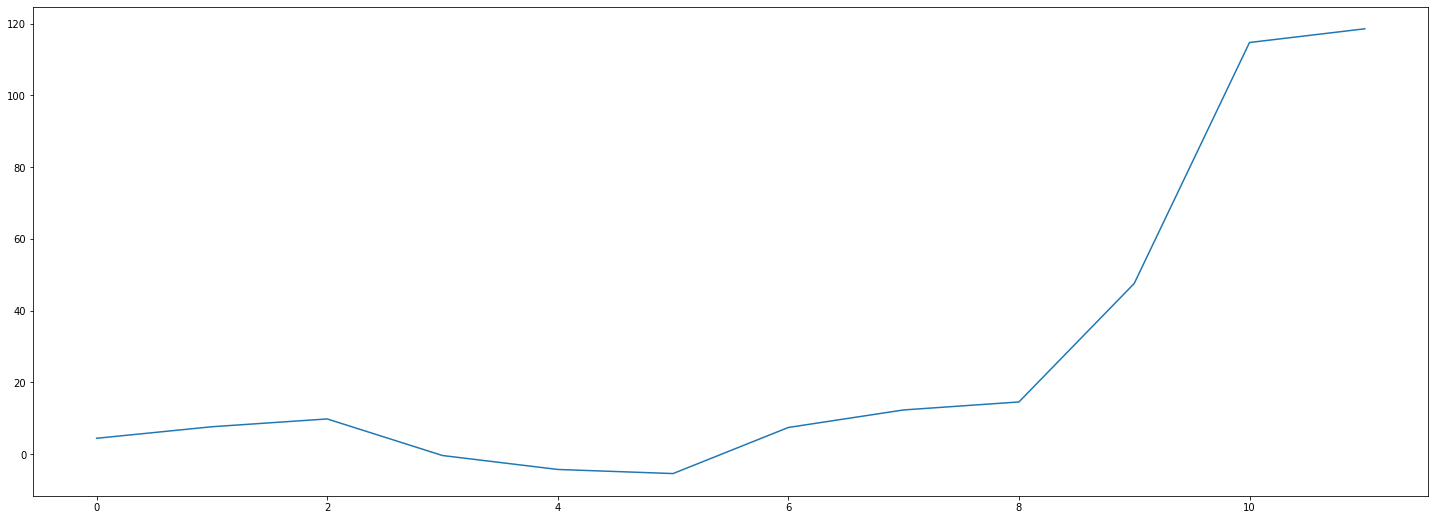

In [28]:
position['income'].cumsum().plot(figsize=(25,9)) # ГРАФИК ДОХОДНОСТИ

In [30]:
day_df1

,date,open,high,low,close,volume,fast_ma,slow_ma,buy_signal,sell_signal,pct_change,STRATEGY
0,2017-03-01,34.4725,35.0375,34.3988,34.9475,135859552.0,33.501105,31.694865,34.9475,NaN,0.020439,0.020439
1,2017-03-02,35.0000,35.0697,34.6525,34.7400,96079508.0,33.626230,31.837802,NaN,NaN,-0.005937,-0.005937
2,2017-03-03,34.6950,34.9575,34.6475,34.9425,75949500.0,33.767355,31.986303,NaN,NaN,0.005829,0.005829
3,2017-03-06,34.8413,34.9425,34.6490,34.8350,76496964.0,33.896230,32.128365,NaN,NaN,-0.003076,-0.003076
4,2017-03-07,34.7650,34.9950,34.6975,34.8800,63654912.0,34.011480,32.263053,NaN,NaN,0.001292,0.001292
...,...,...,...,...,...,...,...,...,...,...,...,...
963,2020-12-24,131.3200,133.4600,131.1000,131.9000,52379452.0,124.887750,120.594615,NaN,NaN,0.006947,0.006947
964,2020-12-28,133.9900,137.3400,133.5100,136.6900,114229847.0,125.899250,121.129365,NaN,NaN,0.036315,0.036315
965,2020-12-29,138.0500,138.7890,134.3409,134.8000,112655196.0,126.660250,121.772615,NaN,NaN,-0.013827,-0.013827
966,2020-12-30,135.5800,135.9900,133.4000,133.7024,86405282.0,127.208870,122.395925,NaN,NaN,-0.008142,-0.008142


БАРЫ ОБЪЕМА НАЧАЛО

In [31]:
  v_s=0
  bd_volume_bar = pd.DataFrame(columns=['DATA', 'CLOSE_price_volume_bar', 'VOL_bar']) # создали пустой датафрейм  с именами колонок
  for i, j in day_df1.iterrows():# i - номер строки j - номер столбца с которого считываем данные
    v_s = v_s + j[5]              #сумма объема
    if v_s >= 40000:
       DATA = j[0]
       CLOSE =j[4]
       VOL_bar = 40000
       new_row = {'DATA': DATA, 'CLOSE_price_volume_bar': CLOSE, 'VOL_bar':VOL_bar} 
       bd_volume_bar = bd_volume_bar.append(new_row, ignore_index=True)
       v_s = 40000-v_s

In [32]:
bd_volume_bar

,DATA,CLOSE_price_volume_bar,VOL_bar
0,2017-03-01,34.9475,40000
1,2017-03-03,34.9425,40000
2,2017-03-06,34.8350,40000
3,2017-03-07,34.8800,40000
4,2017-03-08,34.7500,40000
...,...,...,...
824,2020-12-22,131.7400,40000
825,2020-12-28,136.6900,40000
826,2020-12-29,134.8000,40000
827,2020-12-30,133.7024,40000


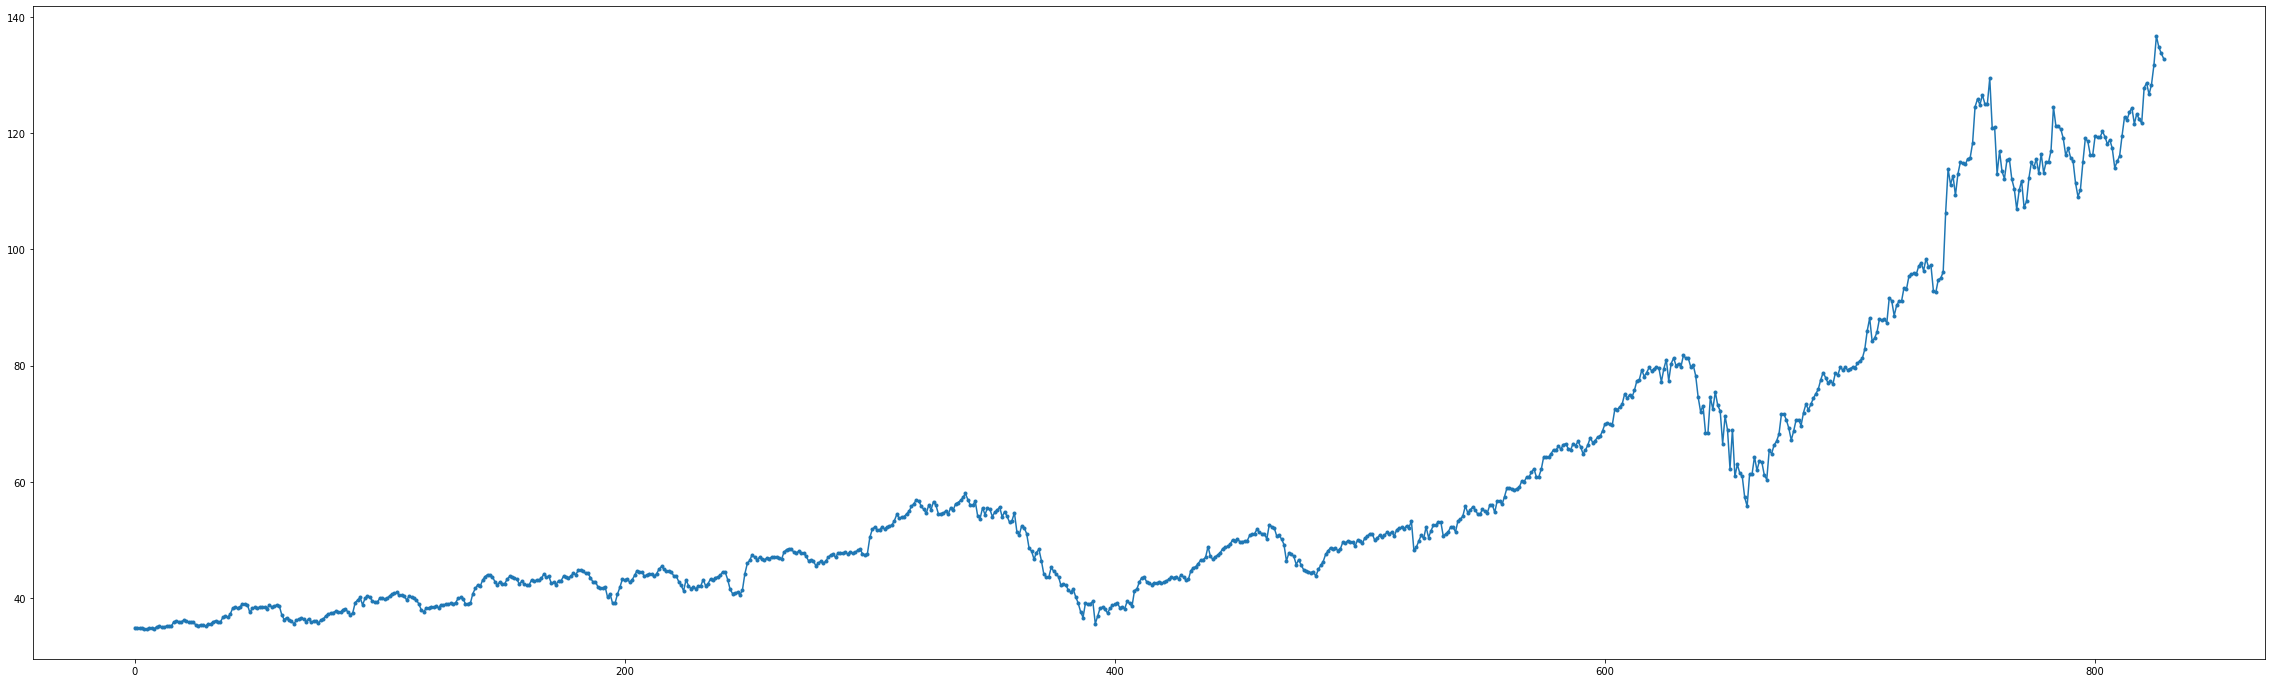

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,12))
#plt.plot(cycle, marker='.')
#plt.plot(bd_tick_bar.PRICE_VWAP[14400:], 'red',marker='.')
plt.plot(bd_volume_bar.CLOSE_price_volume_bar, marker='.')
plt.show()

БАРЫ ОБЪЕМА КОНЕЦ

In [36]:
day_df1

,date,open,high,low,close,volume,fast_ma,slow_ma,buy_signal,sell_signal,pct_change,STRATEGY
0,2017-03-01,34.4725,35.0375,34.3988,34.9475,135859552.0,33.501105,31.694865,34.9475,NaN,0.020439,0.020439
1,2017-03-02,35.0000,35.0697,34.6525,34.7400,96079508.0,33.626230,31.837802,NaN,NaN,-0.005937,-0.005937
2,2017-03-03,34.6950,34.9575,34.6475,34.9425,75949500.0,33.767355,31.986303,NaN,NaN,0.005829,0.005829
3,2017-03-06,34.8413,34.9425,34.6490,34.8350,76496964.0,33.896230,32.128365,NaN,NaN,-0.003076,-0.003076
4,2017-03-07,34.7650,34.9950,34.6975,34.8800,63654912.0,34.011480,32.263053,NaN,NaN,0.001292,0.001292
...,...,...,...,...,...,...,...,...,...,...,...,...
963,2020-12-24,131.3200,133.4600,131.1000,131.9000,52379452.0,124.887750,120.594615,NaN,NaN,0.006947,0.006947
964,2020-12-28,133.9900,137.3400,133.5100,136.6900,114229847.0,125.899250,121.129365,NaN,NaN,0.036315,0.036315
965,2020-12-29,138.0500,138.7890,134.3409,134.8000,112655196.0,126.660250,121.772615,NaN,NaN,-0.013827,-0.013827
966,2020-12-30,135.5800,135.9900,133.4000,133.7024,86405282.0,127.208870,122.395925,NaN,NaN,-0.008142,-0.008142


ТИКОВЫЕ БАРЫ НАЧАЛО

In [37]:
def calculate_bd_tick_bar(bd, colvo_tick_in_bar):# функция с изменеными индексами j[5] всегда обращай внимание если делаешь перестановки столбцов
  v_s=0
  i_s=0
  bd_tick_bar = pd.DataFrame(columns=['DATA', 'CLOSE_price_tick_bar', 'VOL_tick_bar']) # создали пустой датафрейм  с именами колонок
  for i, j in bd.iterrows():# i - номер строки j - номер столбца с которого считываем данные
    v_s = v_s + j[5]              #сумма объема
    i_s = i_s + 1                 #сумма значений которые складываем ( за 15 минут за 30  и тд)
    if i_s == colvo_tick_in_bar:
       DATA = j[0]
       CLOSE =j[4]
       VOL_tick_bar = v_s
       new_row = {'DATA': DATA, 'CLOSE_price_tick_bar': CLOSE, 'VOL_tick_bar':VOL_tick_bar} 
       bd_tick_bar = bd_tick_bar.append(new_row, ignore_index=True)
       v_s = 0
       i_s = 0
  return bd_tick_bar

In [ ]:
bd_tick_bar = calculate_bd_tick_bar(day_df1,10)
bd_tick_bar

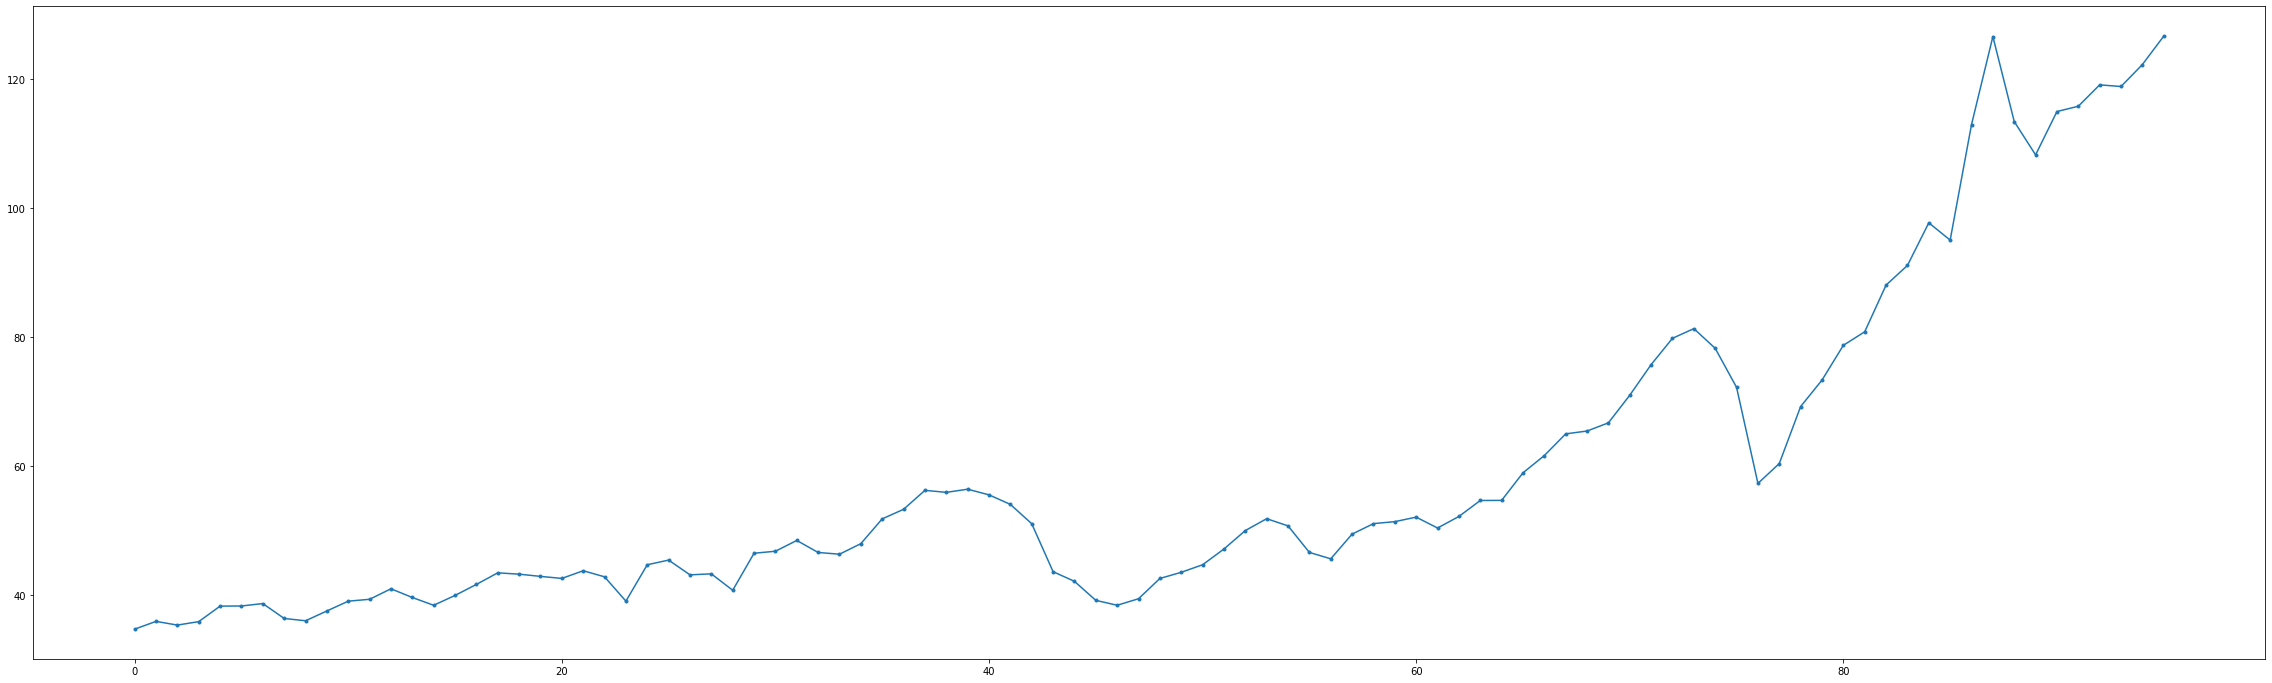

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,12))
#plt.plot(cycle, marker='.')
#plt.plot(bd_tick_bar.PRICE_VWAP[14400:], 'red',marker='.')
plt.plot(bd_tick_bar.CLOSE_price_tick_bar, marker='.')
plt.show()

ТИКОВЫЕ БАРЫ КОНЕЦ